<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/PAPER_GDRNet_AIRQUALITY_Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9/9 [==============================] - 0s 4ms/step


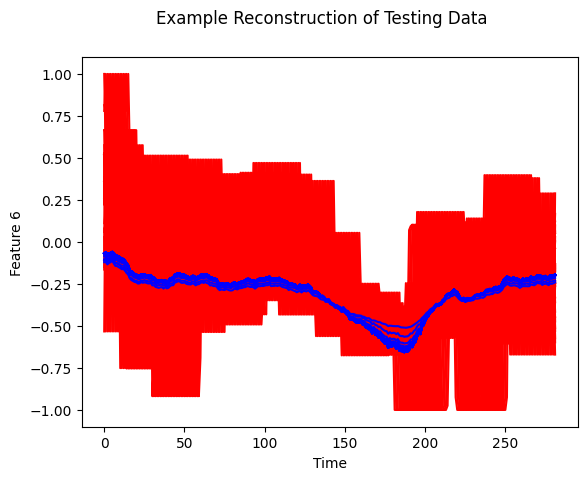

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')

train_data = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TEST_hourly.npy')
window_label = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy')


n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


maxval = train_data.shape[0]
count_train = int(math.ceil(0.8*maxval))
x_train = train_data[:count_train]
x_test = train_data[count_train:]
#x_test = train_data[count_train:,:,:]


#create sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#Build the encoder
latent_dim = 5
intermediate_dim = 256


#Encoder
encoder_inputs =  layers.Input(shape=(window_size, n_features),name="encoder_input")
x = layers.LSTM(intermediate_dim, activation='tanh', name="lstm1", return_sequences=True)(encoder_inputs)
xx = layers.LSTM(int(intermediate_dim/2), activation='tanh', name="lstm2", return_sequences=False)(x)
x1 = layers.Dense(int(intermediate_dim/2), name="dense" )(xx)
z_mean = layers.Dense(latent_dim, name="z_mean")(x1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x1)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


#Dcoder

inp_z = Input(shape=(latent_dim,),name="decoder")
x1 = layers.RepeatVector(window_size, name="repeatvect")(inp_z)
x2= layers.Dense(int(intermediate_dim/2),  name="Dense2")(x1)
x22= layers.LSTM(int(intermediate_dim/2),activation='tanh', return_sequences=True, name="lstm1")(x2)
x3 = layers.LSTM(intermediate_dim,activation='tanh', return_sequences=True, name="lstm2")(x22)
decode_out = layers.TimeDistributed(Dense(n_features), name="decodeout")(x3)
#decode_out = layers.LSTM(n_features,name='decodeout', return_sequences=True)(x2) #Alternative
decoder = keras.Model(inp_z, decode_out, name="decoder")
decoder.summary()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


#Parameters
n_epochs = 100 # total number of epochs
klstart = 3 # The number of epochs at which KL loss should be included
kl_annealtime = n_epochs-klstart
# the starting value of weight is 0
# define it as a keras backend variable
weight = K.variable(0.0)

#Define the VAE as a Model with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,

        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=-1),keepdims=True
                )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            K.print_tensor(weight)
            total_loss = reconstruction_loss + (weight*kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=-1),keepdims=True
                )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                  }



# CALLBACKS
es = keras.callbacks.EarlyStopping(patience=50, verbose=1, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./ kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))

#Train the VAE

vae = VAE(encoder, decoder)



vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1))
history=vae.fit( x_train,
                 epochs=n_epochs,
                 batch_size=32,
                 validation_split=0.1,
                 callbacks=[es,AnnealingCallback(weight),reduce_lr])


encoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-round4-latent5-dim256_1.model')
decoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-round4-latent5-dim256_1.model')

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-round4-latent5-dim256_1.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-round4-latent5-dim256_1.model')

e =
#vae2.evaluate(test_data)

#All loss together

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(history.history['kl_loss'], label='kl_Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['kl_loss'], loc='upper left')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

#Just Loss

plt.plot(history.history['loss'], label='Training Loss')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['kl_loss'], loc='upper left')
plt.legend()
plt.grid(True)
#plt.ylim(0, 100)
plt.show()

#PLOT TRAIN RECONSTRUCTION
X_test_encoded = encoder.predict(x_train)
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')

plt.plot(x_train[:,:,0],"r", label="Actual")
plt.plot(X_test_predict[:,:,0],"b", label="reconstructed")
#plt.legend()
plt.show()

#PLOT TEST RECONSTRUCTION
X_test_encoded = encoder.predict(x_test[:,:,:])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Testing Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_test[:,:,5],"r")
plt.plot(X_test_predict[:,:,5],"b")
plt.show()

fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1],opacity=1, color=window_label.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_traces(marker=dict(size=2))
fig.show()

#--------------------------------------Trysimple encoder--------------------------------------------------------------------------------------

#CONSTRUCT AEC
encoder_inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
LSTM1= LSTM(512,activation='tanh', return_sequences = True)(encoder_inputs)
LSTM2 =LSTM(256, activation='tanh', return_sequences=False)(LSTM1)
decode_bridge = RepeatVector(x_train.shape[1])(LSTM2)
LSTM2_decoded = LSTM(256,activation='tanh', return_sequences=True)(decode_bridge)
LSTM1_decoded = LSTM(512, activation='tanh', return_sequences=True)(LSTM2_decoded)
decoded = TimeDistributed(Dense(x_train.shape[2]))(LSTM1_decoded)
model = Model(encoder_inputs, decoded)

model.summary()
#plot_model(model, to_file=u'/content/drive/MyDrive/PHD/PHD/PMHWORK/TRANSFORMED/model2021.png')

#Compile

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
#TRAIN

history=model.fit(x_train,x_train,epochs=100,
                  validation_split=0.2,
                  batch_size=50,verbose=1,callbacks=[reduce_lr])

#history = model.fit(X_train, X_train, epochs=500, batch_size=32, validation_split=0.1,
#                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


scores = model.evaluate(x_test, x_test, verbose=0)
print(scores)


#Determine Anomaly - train MAE and decide Threshold
x_train_pred = model.predict(x_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


#PLOT TRAIN RECONSTRUCTION
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_train[:,:,0],"r", label="Actual")
plt.plot(x_train_pred[:,:,0],"b", label="reconstructed")
plt.legend()
plt.show()



plt.hist(train_mae_loss, bins=500)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
#PLOT TRAIN RECONSTRUCTION
X_test_encoded = encoder.predict(train_data[0:100,:,:])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')

plt.plot(train_data[90,:,0],"r", label="Actual")
plt.plot(X_test_predict[90,:,0],"b", label="reconstructed")
plt.legend()
plt.show()

#PLOT TEST RECONSTRUCTION
X_test_encoded = encoder.predict(test_data[0:100,:,:])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Testing Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(test_data[50,:,5],"r")
plt.plot(X_test_predict[50,:,5],"b")
plt.show()

fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1],opacity=1, color=window_label.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_traces(marker=dict(size=2))
fig.show()

# serialize autoencoder model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


   #vae2.evaluate(test_data)

# serialize encoder model to JSON
#model_json_encoder = encoder.to_json()
#with open("model_encoder.json", "w") as json_file:
#    json_file.write(model_json_encoder)
# serialize encoder weights to HDF5
#encoder.save_weights("model_encoder.h5")

# serialize whole model to JSON
#vae.save(r'/content/drive/MyDrive/PHD/2021/vae-saved.model')
#modelVAEjson = vae.to_json()
#with open("modelVAE.json", "w") as json_file:
# json_file.write(modelVAE_json)
# serialize weights to HDF5
#vae.save_weights("modelVAE.h5")
#print("Saved model to disk")